# Experiments

In [1]:
from pryngles import *
%load_ext autoreload
%autoreload 2

## Reproducing legacy code results

Let's build a system of our last paper:

In [2]:
import pryngles as pr
from pryngles import Consts
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tqdm import tqdm
import cv2 as cv
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
tmp_dir = "/tmp/"
fig_dir = "/tmp/"
fig_final_dir = "/tmp/"
extension = "cpixx"

def setup_plot(ax,maticksizex,xlim0,xlim1,maticksizey,ylim0,ylim1,notext=False):
    ax.xaxis.set_major_locator(ticker.MultipleLocator(maticksizex))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(maticksizey))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    if notext:
        ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', direction='in', length=10, width=1.00, right=True, top=True)
    ax.tick_params(which='minor', direction='in', length=5, width=0.75, right=True, top=True)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2g"))
    ax.set_xlim([xlim0,xlim1])
    ax.set_ylim([ylim0,ylim1])
    ax.patch.set_alpha(0.0)
    
def add_subplot_axes(ax,rect,facecolor='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

def save_figure(fig, fig_name, fig_dir='/tmp', 
                dpi=100, formats=['png'],quiet=False,
                **options):
    """Save a figure to different image formats
    
    Available formats: png, svg, eps
    """
    for form in formats:
        fig_file = fig_dir + fig_name + '.' + form
        if not quiet:
            print(f"Saving {fig_file}...")
        fig.savefig(fig_file,format=form,dpi=dpi,bbox_inches='tight',**options)
        
def save_planet_views(RP,suffix=None,quiet=False):
    if not suffix:
        suffix=f"oi_{RP.iorb}-rl_{RP.alphar}-ri_{RP.gamma}"
    ecl_fig,obs_fig,star_fig = RP.plotRingedPlanet(showstar=False,showfig=False,showtitle=False,axis=False)
    for rf in "ecl","obs","star":
        fig=eval(f"{rf}_fig")
        save_figure(fig,f"config-{suffix}-{rf}",
                    fig_dir=fig_dir, dpi=300, formats=["png"], quiet=quiet)
        
def convert_normal_vectors(i,phi):
    """This routine convert the inclination parameters normally 
    reported in literature to Pryngles input angles (gamma and lambr)
    
    Parameters:
        i: float [degrees]:
            Inclination with respect to the plane of the sky, 90 is edge-on, 0 is face-on.
        phi: float [degrees]: 
            Roll-angle in the plane of the sky.
            
    Return:
        gamma: float [degrees]:
            Inclination with respect to the plane of the sky, 90 is edge-on, 0 is face-on.
        lambr: float [degrees]:
            Roll angle.
    """
    def func(x,i,phi):
        return [np.sin(x[1])*np.cos(x[0]) - np.sin(phi)*np.sin(i),
                np.sin(x[0]) - np.cos(phi)*np.sin(i),
                np.cos(x[1])*np.cos(x[0]) - np.cos(i)]
    fit = least_squares(func, np.array([60*Consts.deg,40*Consts.deg]), 
                        args=(i*Consts.deg,phi*Consts.deg))
    gamma, lambr = fit.x
    return gamma*Consts.rad,lambr*Consts.rad,fit.fun

def notqdm(x):return x

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Index file /tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 128 files in data repository.
File /tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
File /tmp//fou_ring_1_0_0_8.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['/tmp//fou_bmsca10.0_asurf0.5.dat', '/tmp//fou_ring_1_0_0_8.dat']
Fourier coefficients files required: ['fou_bmsca10.0_asurf0.5.dat', 'fou_ring_1_0_0_8.dat']
Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 10.0 deg
	Inclination of the observer w.r.t ecliptic: 20.0 deg
	Initial longitude of the observer: 60.0 deg
	Initial longitude of the star: 30.0 deg


<IPython.core.display.Javascript object>


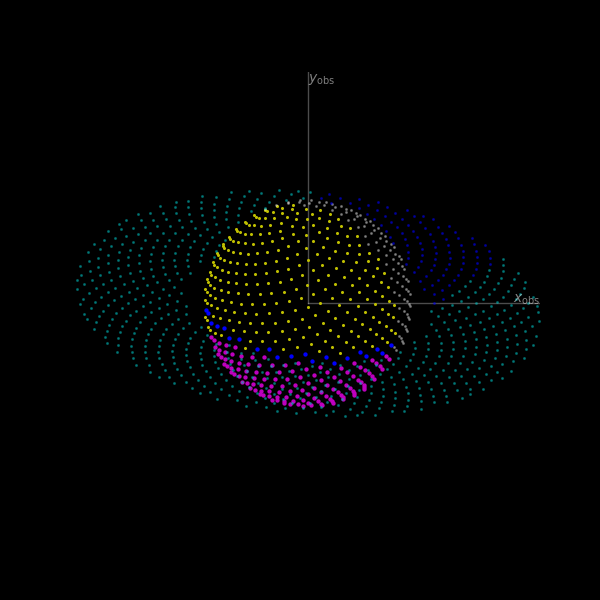

In [3]:
# Optical parameters
tau_ring = 1.0 # Optical thickness of the ring
omegar = 0.8 # Single scattering albedo of ring particles
bp = 10.0 # Optical thickness of planet atmosphere
omegap = 0.5 # Albedo of planet surface

# Planet and ring size
Rs = Consts.rsun # Stellar radius in m
Rp = Consts.rsaturn # Planet radius in m
ring_ri = 1.2
ring_re = 2.25

# Orbital properties
a = 1.0 # au
e = 0.0 

# Number of spangles
resolution = 1 # Resolution factor. For production purposes use resolution = 10
Np = int(1000*resolution) # Number of spangles in planet
Nr = int(1000*resolution) # Number of spangles in ring
Ns = 30
Nb = 0

#"""
ir = 10.0
alpha = 0.0
beta_obs = 20.0
lamb_obs = 60.0
lamb_star = 30.0
#"""
"""
ir = 30.0
beta_obs = 0.0
lamb_obs = 90.0
lamb_star = 0.0
#"""
# Fourier coefficients file
fou_file_planet = f'fou_bmsca{bp:.1f}_asurf{omegap:.1f}.dat'
fou_file_ring = f'fou_ring_{str(tau_ring).replace(".","_")}_{str(omegar).replace(".","_")}.dat'

# Check if coefficients file are available in data repo 
pr.Misc.retrieve_data([fou_file_planet,fou_file_ring],path=tmp_dir,overwrite=False,quiet=False)
print(f"Fourier coefficients files required: {[fou_file_planet,fou_file_ring]}")

# Report conditions
print(f"Initial conditions in the planet-centered system are:")
print(f"\tRing inclination w.r.t. ecliptic: {ir:.1f} deg")
print(f"\tInclination of the observer w.r.t ecliptic: {beta_obs:.1f} deg")
print(f"\tInitial longitude of the observer: {lamb_obs:.1f} deg")
print(f"\tInitial longitude of the star: {lamb_star:.1f} deg")

# Create system
sys = pr.System(units=['au','msun','yr2pi'])

S=sys.add(
    kind="Star",
    physics=dict(radius=Rs/sys.ul),
    optics=dict(limb_coeffs=[0.65])
)

P=sys.add(
    kind="Planet", primary=S,
    radius=Rp/sys.ul,
    orbit=dict(a=a, e=e),
    physics=dict(radius=Rp/sys.ul),
    optics=dict(nspangles=Np)
)

R=sys.add(
    kind="Ring", primary=P,
    physics=dict(fi=ring_ri, fe=ring_re, i=ir*Consts.deg, taur=tau_ring),
    optics=dict(nspangles=Nr)
)

RP=sys.ensamble_system(extension=extension,
                       fname_planet=tmp_dir + fou_file_planet,
                       fname_ring=tmp_dir + fou_file_ring)

# Set observer and stellar position
RP.changeObserver([lamb_obs*Consts.deg,beta_obs*Consts.deg])
RP.changeStellarPosition(lamb_star*Consts.deg)
RP.updateSpangles()

"""
#gamma = 90-np.arctan2(nr_obs[2],(nr_obs[0]**2+nr_obs[1]**2)**0.5)*Consts.rad
nr_obs=pr.spy.mxv(RP.M_ecl2obs,RP.nr_ecl)
lambr = 90 - np.arctan2(nr_obs[2],nr_obs[0])*Consts.rad
RP.io*Consts.rad,lambr
ir, beta_obs, lamb_obs, lamb_star = pr.Util.calcStartingPosition(iorb,gamma,lambr)

print(iorb,gamma,lambr)
print(f"Initial conditions in the planet-centered system are:")
print(f"\tRing inclination w.r.t. ecliptic: {ir*Consts.rad:.1f} deg")
print(f"\tInclination of the observer w.r.t ecliptic: {beta_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the observer: {lamb_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the star: {lamb_star*Consts.rad:.1f} deg")
"""

# Preview
ecl_fig,obs_fig,star_fig = RP.plotRingedPlanet(showstar=False,showfig=False,showtitle=False,axis=True)
obs_fig

Get the spangle coordinates

Saving /tmp/config-oi_70.0-rl_0.0-ri_10.0-ecl.png...
Saving /tmp/config-oi_70.0-rl_0.0-ri_10.0-obs.png...
Saving /tmp/config-oi_70.0-rl_0.0-ri_10.0-star.png...


100%|██████████| 36/36 [00:01<00:00, 25.79it/s]


<IPython.core.display.Javascript object>


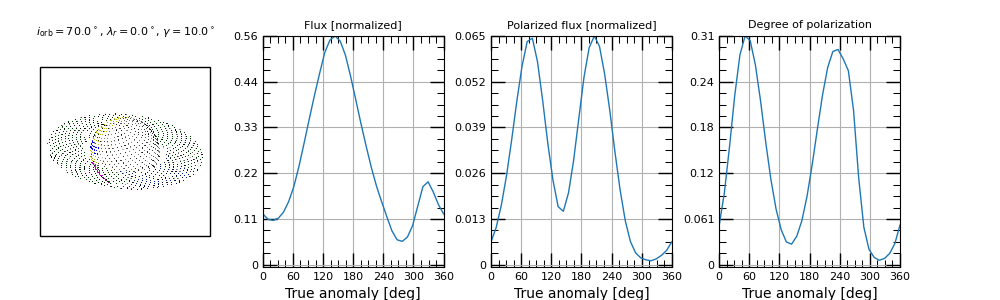

In [5]:
# Properties
iorb = 90 - beta_obs
gamma = ir
lambr = alpha

# Update additional properties
RP.behavior["interp_method_ring"] = 'spline'
RP.reference_plane = 'Detector'
RP.iorb = iorb
RP.gamma = gamma
RP.alphar = lambr
RP.Ns = Ns
RP.Np = Np
RP.Nr = Nr
RP.Nb = Nb

# Views
save_planet_views(RP,quiet=False)

# Ecliptic longitude interval
nlambs = 36
lamb_initial = lamb_star
lamb_final = lamb_initial + 360*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,nlambs)

# Compute polarimetric curve
LC=RP.compute_polarimetic_curve(lambs,normalize=True,progress=tqdm)
true_anomaly = (LC[:,0]-lamb_initial)*Consts.rad

# Check normalization
if RP.LC_normalized:
    normfactor = 1
    units = ' [normalized]'
else:
    units = 'ppm'
    normfactor = 1e6
    units = rf' [{units}]'

#Create figure
fsize=1
plt.rcParams.update({'font.size': 8*fsize})
fig = plt.figure(figsize=(10*fsize,3*fsize))
gs = fig.add_gridspec(ncols=4, nrows=1, wspace = 0.3, width_ratios= [0.5,1,1,1])
axs = gs.subplots(sharex=True)

# Get configuration image
figure_loc = fig_dir + f"config-oi_{iorb}-rl_{lambr}-ri_{gamma}-obs.png"
figure = cv.imread(figure_loc)
b,g,r = cv.split(figure)
tmp = cv.cvtColor(figure, cv.COLOR_BGR2GRAY)
tmp,alp = cv.threshold(tmp,0,255,cv.THRESH_BINARY)
rgba = [r,g,b,alp]
figure = cv.merge(rgba,4)

# Add image and labels
imagebox = OffsetImage(figure,zoom=0.08)
ab = AnnotationBbox(imagebox,(0.5,0.5),frameon=True,transform=axs[0].transAxes)
axs[0].add_artist(ab)
axs[0].text(1,1,rf'$i_{{\rm orb}} = {iorb}^\circ$, $\lambda_r = {lambr}^\circ$, $\gamma = {gamma}^\circ$',
            ha='right',transform=axs[0].transAxes,fontsize=8*fsize)
axs[0].set_axis_off()

# Plot light-curve
axs[1].plot(true_anomaly,LC[:,1]*normfactor,linestyle='-',linewidth=1*fsize)
axs[2].plot(true_anomaly,LC[:,2]*normfactor,linestyle='-',linewidth=1*fsize)
axs[3].plot(true_anomaly,abs(LC[:,3]),linestyle='-',linewidth=1*fsize)

#Decoration
axs[1].set_title(f"Flux{units}",fontsize=8*fsize)
axs[2].set_title(f"Polarized flux{units}",fontsize=8*fsize)
axs[3].set_title(f"Degree of polarization",fontsize=8*fsize)

Fmax=LC[:,1].max()*normfactor
PFmax=LC[:,2].max()*normfactor
Pmax=abs(LC[:,3]).max()
dF=Fmax/5
dPF=PFmax/5
dP=Pmax/5
        
notext=True
setup_plot(axs[1],60,0,360,dF,-Fmax/100,Fmax,notext=notext)
setup_plot(axs[2],60,0,360,dPF,-PFmax/100,PFmax,notext=notext)
setup_plot(axs[3],60,0,360,dP,-Pmax/100,Pmax,notext=notext)

for ax in axs[1:]:
    ax.grid()
    ax.set_xlabel("True anomaly [deg]",fontsize=10)

To find the equivalent system in the case of the `System` interface we use the transformation:

$$
\lambda_{\rm p} = \pi + \lambda_{\rm star}
$$
where $\lambda_{\rm p}$ ($\lambda_{\rm star}$) is the initial ecliptic longitude of the planet (star) in the system of reference of the star (of the planet). 

VERB0::elapsed_time:: Spangling time: 1.69256 s = 1.69 s


<IPython.core.display.Javascript object>


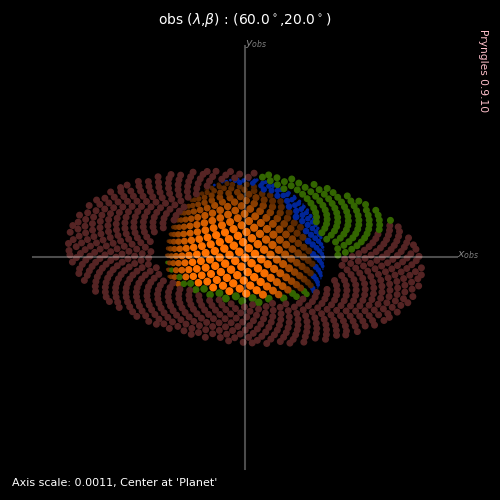

<IPython.core.display.Javascript object>


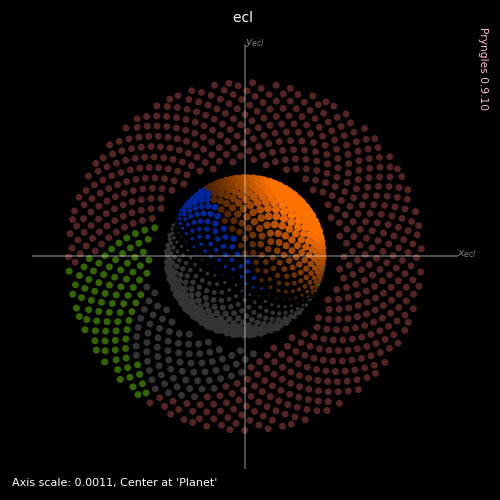

(-0.7872958206690396, -0.4545454566053532)

In [6]:
sys = pr.System(units=['au','msun','yr2pi'])

S=sys.add(
    kind="Star",
    physics=dict(radius=Rs/sys.ul),
    optics=dict(limb_coeffs=[0.65])
)

# We initialize planet and ring with the spangles from the RingedPlanet interface
P=sys.add(
    kind="Planet", primary=S,
    radius=Rp/sys.ul,
    orbit=dict(a=a, e=e, M=(180*Consts.deg+lamb_star*Consts.deg)),
    physics=dict(radius=Rp/sys.ul),
    optics=dict(nspangles=RP.rps_equ/RP.Rp),
    #optics=dict(nspangles=Np),
    preset=False
)
R=sys.add(
    kind="Ring", primary=P,
    physics=dict(fi=ring_ri, fe=ring_re, i=ir*Consts.deg, roll=90*Consts.deg, taur=tau_ring),
    optics=dict(nspangles=RP.rrs_equ/RP.Re),
    #optics=dict(nspangles=Nr),
    preset=False
)

sys.initialize_simulation()
sys.spangle_system()

sys.update_perspective(pr.Science.direction(lamb_obs,beta_obs))
sys.sg.plot2d(coords='obs',include=[P,R])
sys.sg.plot2d(coords='ecl',include=[P,R])

Now the coordinates of the spangles both in the legacy as well as in the new interface are the same:

In [7]:
RP.rps_equ/RP.Rp

array([[-0.03296789,  0.03020129, -0.999     ],
       [ 0.00676689, -0.07710518, -0.997     ],
       [ 0.06076778,  0.07926081, -0.995     ],
       ...,
       [ 0.02961953,  0.09538178,  0.995     ],
       [-0.06685793, -0.03900022,  0.997     ],
       [ 0.04471018,  0.        ,  0.999     ]])

In [8]:
P.sg.sample.ss

array([[-0.03296789,  0.03020129, -0.999     ],
       [ 0.00676689, -0.07710518, -0.997     ],
       [ 0.06076778,  0.07926081, -0.995     ],
       ...,
       [ 0.02961953,  0.09538178,  0.995     ],
       [-0.06685793, -0.03900022,  0.997     ],
       [ 0.04471018,  0.        ,  0.999     ]])

In [9]:
(RP.eps_equ-P.sg.sample.pp[:,1:]).max()

9.370282327836321e-14

In [10]:
RP.rps_equ*S.radius

array([[-1.32816664e-05,  1.21670944e-05, -4.02463830e-04],
       [ 2.72615327e-06, -3.10631104e-05, -4.01658097e-04],
       [ 2.44813163e-05,  3.19315419e-05, -4.00852363e-04],
       ...,
       [ 1.19327211e-05,  3.84261419e-05,  4.00852363e-04],
       [-2.69348330e-05, -1.57118907e-05,  4.01658097e-04],
       [ 1.80122416e-05,  0.00000000e+00,  4.02463830e-04]])

In [11]:
P.sg.data.x_equ

0     -0.000013
1      0.000003
2      0.000024
3     -0.000047
4      0.000046
         ...   
995   -0.000050
996    0.000020
997    0.000012
998   -0.000027
999    0.000018
Name: x_equ, Length: 1000, dtype: float64

Let's check the other properties, for instance the state of the spangles:

In [12]:
RP.vpo.sum()

499

In [69]:
RP.vpo[:100]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
        True])

In [72]:
cond=(P.sg.data.visible)
np.array(cond[:100])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [60]:
RP.rps_equ[RP.vpo]*S.radius

array([[ 1.50721609e-04,  1.40802426e-04, -3.46062492e-04],
       [ 9.80009107e-05,  1.93282034e-04, -3.39616625e-04],
       [ 1.91751907e-04,  1.13637598e-04, -3.35587958e-04],
       ...,
       [ 1.19327211e-05,  3.84261419e-05,  4.00852363e-04],
       [-2.69348330e-05, -1.57118907e-05,  4.01658097e-04],
       [ 1.80122416e-05,  0.00000000e+00,  4.02463830e-04]])

In [49]:
cond=(P.sg.data.visible)
print_df(P.sg.data[cond].head(10))

,name,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,wx_ecl,wy_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cosf_int,cos_int,azim_int,n_int,n_int_ecl,d_int,asp_int,z_cen_int,hidden_by_int,transit_over_int,string_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cosf_obs,cos_obs,azim_obs,n_obs,d_obs,asp_obs,z_cen_obs,hidden_by_obs,transit_over_obs,beta_loc,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cosf_luz,cos_luz,azim_luz,n_luz,d_luz,asp_luz,z_cen_luz,hidden_by_luz,transit_over_luz,azim_obs_luz,asp,dsp,scatterer,albedo_gray_normal,albedo_gray_spherical,tau_gray_optical,F,Q,U,V,P,emmitter,Teq,Tem,emmisivity,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
500,Planet,0,1,0.000403,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",-0.000266,0.000302,4.028667e-07,0.000403,2.293184,0.001000,"[-0.661177843664428, 0.7502285378784637, 0.001000000000000112]","[-0.7872958216222175, -0.45454545454545364, 0.0]",-0.787598,-0.454812,4.028667e-07,"[-0.0007502289129931322, -0.000661178174253702, -0.9999994999998749]","[0.6611781742535976, -0.7502289129930138, 0.0]","[-0.7502285378784637, -0.661177843664428, 0.0010000000000001579]","[0.0, 0.0, 0.0]",-0.000302,-0.000266,4.028667e-07,"[-0.7502285378784637, -0.661177843664428, 0.0010000000000001579]",0.000403,3.863981,0.001,0.001,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,2.039542e-09,-inf,,,,"[0.0, 0.0, 0.0]",-0.000302,-0.000266,0.0,"[-0.7502285378784637, -0.661177843664428, 0.0010000000000001579]",0.000403,3.863981,0.001,0.001,3.141593,"[0, 0, 1]",inf,0.0,-inf,,,0,"[0.0, 0.0, 0.0]",-0.000302,-0.000266,0.0,"[-0.7502285378784637, -0.661177843664428, 0.0010000000000001579]",0.000403,3.863981,0.001,0.001,3.141593,"[0, 0, 1]",inf,0.0,-inf,,,0.0,2.039542e-09,0.000051,,1.0,1.0,0.0,0,0,0,0,0,,273.15,273.15,1,False,False,False,True,False,False,False,False,False,True,False,False,False
501,Planet,0,1,0.000403,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",-0.000008,-0.000403,1.208600e-06,0.000403,4.693148,0.003000,"[-0.01924005406107704, -0.9998103921843016, 0.0030000000000001137]","[-0.7872958216222175, -0.45454545454545364, 0.0]",-0.786893,-0.454553,1.208600e-06,"[0.00299944467408436, -5.7720421925715215e-05, -0.9999954999898749]","[0.019240140641904734, 0.9998148913614358, -0.0]","[0.9998103921843016, -0.01924005406107704, 0.0030000000000000525]","[0.0, 0.0, 0.0]",0.000403,-0.000008,1.208600e-06,"[0.9998103921843016, -0.01924005406107704, 0.0030000000000000525]",0.000403,6.263944,0.003,0.003,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,2.039542e-09,-inf,,,,"[0.0, 0.0, 0.0]",0.000403,-0.000008,0.000001,"[0.9998103921843016, -0.01924005406107704, 0.0030000000000000525]",0.000403,6.263944,0.003,0.003,3.141593,"[0, 0, 1]",inf,0.0,-inf,,,0,"[0.0, 0.0, 0.0]",0.000403,-0.000008,0.000001,"[0.9998103921843016, -0.01924005406107704, 0.0030000000000000525]",0.000403,6.263944,0.003,0.003,3.141593,"[0, 0, 1]",inf,0.0,-inf,,,0.0,2.039542e-09,0.000051,,1.0,1.0,0.0,0,0,0,0,0,,273.15,273.15,1,False,False,False,True,False,False,False,False,False,True,False,False,False
502,Planet,0,1,0.000403,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",0.000278,0.000292,2.014333e-06,0.000403,0.809926,0.005000,"[0.6895437166339053, 0.7242268034605597, 0.0050000000000001155]","[-0.7872958216222175, -0.45454545454545364, 0.0]",-0.787588,-0.454268,2.014333e-06,"[-0.003621179282326852, 0.0034477616804600027, -0.9999874999218739]","[-0.6895523360919785, -0.7242358564653473, 0.0]","[-0.7242268034605597, 0.6895437166339053, 0.00500000000000016]","[0.0, 0.0, 0.0]",-0.000292,0.000278,2.014333e-06,"[-0.7242268034605597, 0.6895437166339053, 0.00500000000000016]",0.000403,2.380722,0.005,0.005,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,2.039542e-09,-inf,,,,"[0.0, 0.0, 0.0]",-0.000292,0.000278,0.000002,"[-0.7242268034605597, 0.6895437166339053, 0.00

In [18]:

print_df(P.sg.data.head(10))

,name,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,wx_ecl,wy_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cosf_int,cos_int,azim_int,n_int,n_int_ecl,d_int,asp_int,z_cen_int,hidden_by_int,transit_over_int,string_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cosf_obs,cos_obs,azim_obs,n_obs,d_obs,asp_obs,z_cen_obs,hidden_by_obs,transit_over_obs,beta_loc,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cosf_luz,cos_luz,azim_luz,n_luz,d_luz,asp_luz,z_cen_luz,hidden_by_luz,transit_over_luz,azim_obs_luz,asp,dsp,scatterer,albedo_gray_normal,albedo_gray_spherical,tau_gray_optical,F,Q,U,V,P,emmitter,Teq,Tem,emmisivity,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,Planet,0,1,0.000403,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",-0.000013,0.000012,-0.000402,0.000403,2.399963,-1.526071,"[-0.032967893652075905, 0.030201291166858844, -0.9990000000000001]","[-0.7872958216222175, -0.45454545454545364, 0.0]",-0.787308,-0.454559,-0.000402,"[0.6748148039672631, 0.7366315092002409, -0.04471017781221606]","[0.7373688780783192, -0.6754902942615246, 0.0]","[-0.030201291166858907, -0.032967893652075905, -0.9990000000000001]","[0.0, 0.0, 0.0]",-0.000012,-0.000013,-0.000402,"[-0.030201291166858907, -0.032967893652075905, -0.9990000000000001]",0.000018,3.970760,-0.999,-0.999,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,2.039542e-09,-inf,,,,"[0.0, 0.0, 0.0]",-0.000012,-0.000013,-0.000402,"[-0.030201291166858907, -0.032967893652075905, -0.9990000000000001]",0.000018,3.97076,-0.999,-0.999,3.141593,"[0, 0, 1]",inf,0.0,-inf,,,0,"[0.0, 0.0, 0.0]",-0.000012,-0.000013,-0.000402,"[-0.030201291166858907, -0.032967893652075905, -0.9990000000000001]",0.000018,3.97076,-0.999,-0.999,3.141593,"[0, 0, 1]",inf,0.0,-inf,,,0.0,2.039542e-09,0.000051,,1.0,1.0,0.0,0,0,0,0,0,,273.15,273.15,1,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Planet,0,1,0.000403,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",0.000003,-0.000031,-0.000402,0.000403,4.799926,-1.493317,"[0.006766886635494427, -0.07710518299869559, -0.997]","[-0.7872958216222175, -0.45454545454545364, 0.0]",-0.787265,-0.454543,-0.000402,"[-0.9931825277422333, -0.08716344754280905, -0.07740155037206917]","[-0.08742572471695993, 0.9961710408648278, 0.0]","[0.07710518299869554, 0.006766886635494427, -0.997]","[0.0, 0.0, 0.0]",0.000031,0.000003,-0.000402,"[0.07710518299869554, 0.006766886635494427, -0.997]",0.000031,0.087537,-0.997,-0.997,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,2.039542e-09,-inf,,,,"[0.0, 0.0, 0.0]",0.000031,0.000003,-0.000402,"[0.07710518299869554, 0.006766886635494427, -0.997]",0.000031,0.087537,-0.997,-0.997,3.141593,"[0, 0, 1]",inf,0.0,-inf,,,0,"[0.0, 0.0, 0.0]",0.000031,0.000003,-0.000402,"[0.07710518299869554, 0.006766886635494427, -0.997]",0.000031,0.087537,-0.997,-0.997,3.141593,"[0, 0, 1]",inf,0.0,-inf,,,0.0,2.039542e-09,0.000051,,1.0,1.0,0.0,0,0,0,0,0,,273.15,273.15,1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Planet,0,1,0.000403,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",0.000024,0.000032,-0.000401,0.000403,0.916704,-1.470755,"[0.06076778364646691, 0.07926081295757789, -0.995]","[-0.7872958216222175, -0.45454545454545364, 0.0]",-0.787328,-0.454521,-0.000401,"[0.7896327475352378, -0.6053966666739682, -0.09987492177719073]","[-0.6084388609788625, -0.7936007512916963, 0.0]","[-0.07926081295757795, 0.06076778364646691, -0.995]","[0.0, 0.0, 0.0]",-0.000032,0.000024,-0.000401,"[-0.07926081295757795, 0.06076778364646691, -0.995]",0.000040,2.487501,-0.995,-0.995,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,2.039542e-09,-inf,,,,"[0.0, 0.0, 0.0]",-0.000032,0.000024,-0.000401,"[-0.07926081295757795, 0.06076778364646691, -0.995]",0.00004,2.487501,-0.995,-0.995,3.141593,"[0, 0, 1]",inf,0.0,-inf,,,0,"[0.0, 0.0, 0.0]",-0.000032,0

In [34]:
P.sg.data.x_equ

0     -0.000013
1      0.000003
2      0.000024
3     -0.000047
4      0.000046
         ...   
995   -0.000050
996    0.000020
997    0.000012
998   -0.000027
999    0.000018
Name: x_equ, Length: 1000, dtype: float64

## Refactoring tests

In [8]:
Consts.get_all()

['ABC',
 'BODY_DEFAULTS',
 'BODY_KINDS',
 'DATA_INDEX',
 'DEG',
 'DOUBLE',
 'FILE',
 'GSI',
 'HASH_MAXSIZE',
 'IN_JUPYTER',
 'LEGACY_PHYSICAL_PROPERTIES',
 'NORMFACTOR',
 'OBSERVER_DEFAULTS',
 'PDOUBLE',
 'PLANET_DEFAULTS',
 'PPDOUBLE',
 'PPPDOUBLE',
 'RAD',
 'REBOUND_CARTESIAN_PROPERTIES',
 'REBOUND_ORBITAL_PROPERTIES',
 'RING_DEFAULTS',
 'ROOTDIR',
 'SAMPLER_CIRCLE_PRESETS',
 'SAMPLER_GEOMETRY_CIRCLE',
 'SAMPLER_GEOMETRY_SPHERE',
 'SAMPLER_MIN_RING',
 'SAMPLER_PRESETS',
 'SAMPLER_SPHERE_PRESETS',
 'SAMPLE_SHAPES',
 'SCATTERERS_CATALOGUE',
 'SCIENCE_LIMB_NORMALIZATIONS',
 'SHADOW_COLOR_LUZ',
 'SHADOW_COLOR_OBS',
 'SPANGLER_AREAS',
 'SPANGLER_COLUMNS',
 'SPANGLER_COLUMNS_DOC',
 'SPANGLER_COL_COPY',
 'SPANGLER_COL_INT',
 'SPANGLER_COL_LUZ',
 'SPANGLER_COL_OBS',
 'SPANGLER_DEBUG_FIELDS',
 'SPANGLER_EPS_BORDER',
 'SPANGLER_EQUIV_COL',
 'SPANGLER_KEY_ORDERING',
 'SPANGLER_KEY_SUMMARY',
 'SPANGLER_LENGTHS',
 'SPANGLER_SOURCE_STATES',
 'SPANGLER_VECTORS',
 'SPANGLER_VISIBILITY_STATES',
 'SPA

In [9]:
Consts.get_physical()

['au',
 'aus',
 'cm',
 'd',
 'day',
 'days',
 'deg',
 'g',
 'gram',
 'gyr',
 'hr',
 'jyr',
 'kg',
 'km',
 'kyr',
 'm',
 'mearth',
 'mjupiter',
 'mmars',
 'mmercury',
 'mneptune',
 'mpluto',
 'msaturn',
 'msolar',
 'msun',
 'muranus',
 'mvenus',
 'myr',
 'parsec',
 'pc',
 'ppb',
 'ppm',
 'rad',
 'rearth',
 'rjupiter',
 'rsaturn',
 'rsun',
 's',
 'solarmass',
 'sunmass',
 'yr',
 'yrs']

In [13]:
units.times_SI

{'s': 1.0,
 'hr': 3600.0,
 'day': 86400.0,
 'days': 86400.0,
 'd': 86400.0,
 'yr': 31557600.0,
 'yrs': 31557600.0,
 'jyr': 31557600.0,
 'sidereal_yr': 31558149.7635,
 'yr2pi': 5022642.89091303,
 'kyr': 31557600000.0,
 'myr': 31557600000000.0,
 'gyr': 3.15576e+16}

In [17]:
%matplotlib nbagg

In [21]:
len(plt.get_fignums())

1

<IPython.core.display.Javascript object>


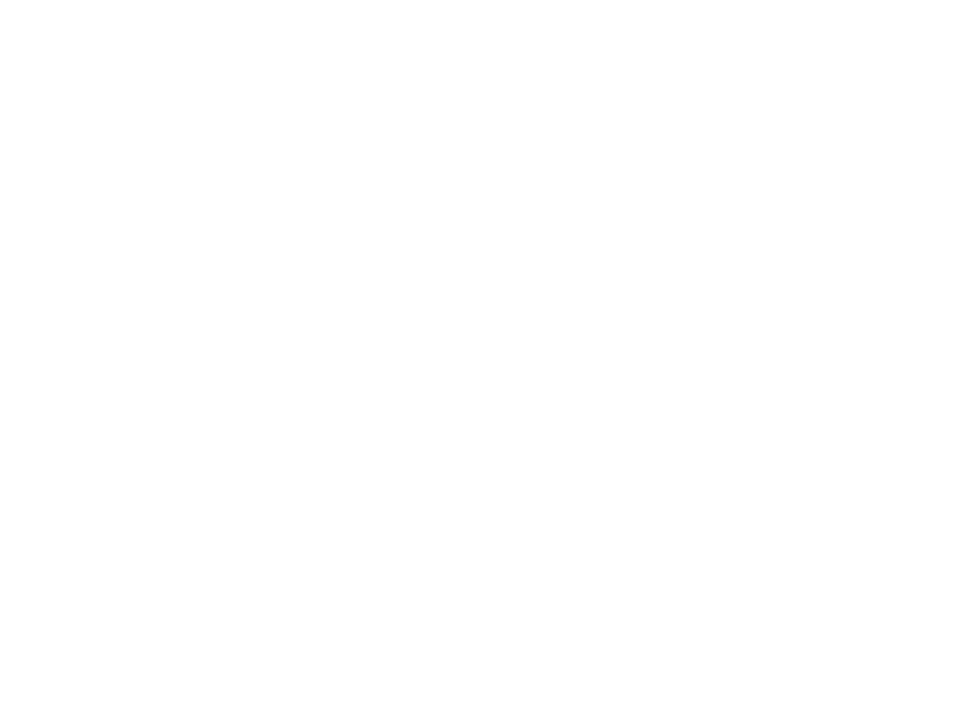

<IPython.core.display.Javascript object>


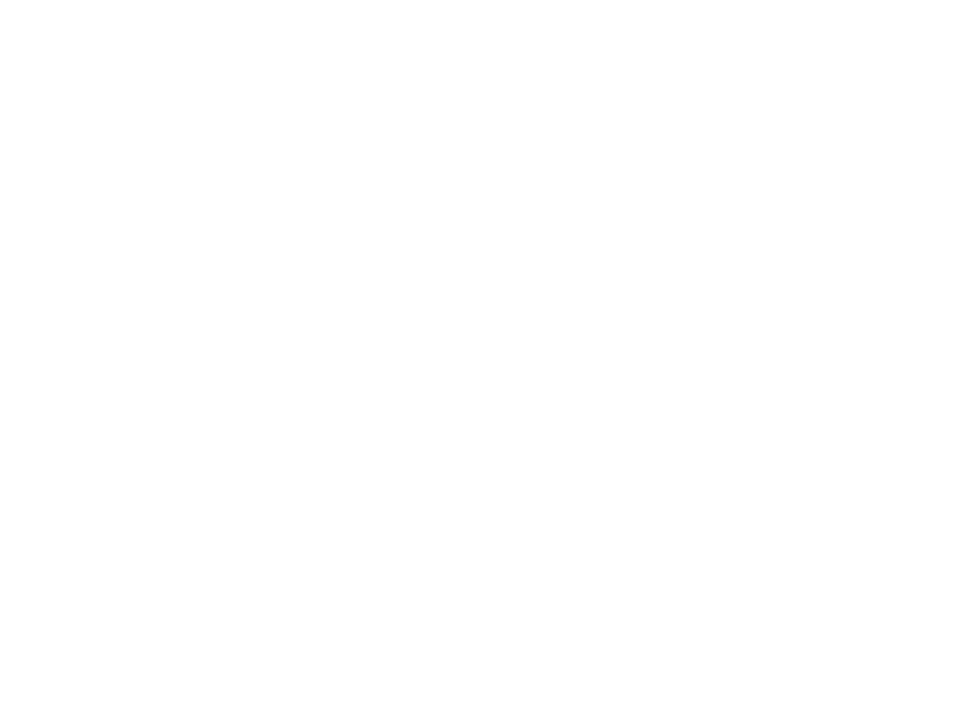

In [19]:
plt.figure()

## Playing ground

Catalogue of scatterers:

In [68]:
SCATTERERS_CATALOGUE

{'12639246600797894399': <__main__.MySurface at 0x7fdd8ad95550>,
 '17386778346896613912': <__main__.NeutralSurface at 0x7fdd8ad6e7c0>,
 '2753295789858012128': <__main__.BlackBodySurface at 0x7fdd8ad6e9a0>,
 '8444787382930178394': <__main__.LambertianGraySurface at 0x7fdd8ad888b0>,
 '13726343987531483060': <__main__.LambertianGrayAtmosphere at 0x7fdd68b5e7f0>,
 '14563942549452617125': <pryngles.scatterer.LambertianGrayAtmosphere at 0x7fdd68b5efd0>,
 '745845182321881531': <pryngles.scatterer.LambertianGraySurface at 0x7fdd68bbee20>,
 '14366390467869099438': <__main__.CustomSurface at 0x7fdd69d62910>}

Create system:

In [17]:
nspangles=50

sys=System()
S=sys.add(kind="Star",nspangles=nspangles,
          radius=Consts.rsun/sys.ul,limb_coeffs=[0.65])
P=sys.add(kind="Planet",parent=S,nspangles=nspangles,
          a=0.2,e=0.0,radius=Consts.rsaturn/sys.ul,spangle_type=0)
R=sys.add(kind="Ring",parent=P,nspangles=nspangles,
          fi=1.5,fe=2.5,i=30*Consts.deg,roll=-90*Consts.deg)

In [19]:
sys.spangle_scatterers

{2: (pryngles.scatterer.LambertianGrayAtmosphere,
  {'AS': 'albedo_gray_spherical'}),
 4: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 3: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 1: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 0: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 5: (pryngles.scatterer.BlackBodySurface, {}),
 6: (pryngles.scatterer.BlackBodySurface, {})}

Define a custom surface scatterer:

In [21]:
class CustomSurface(Scatterer):
    """Black body surface
    """
    def __init__(self,**params):
        if self.register(self,params):
            self.U=params["U"]
            self.V=params["V"]
    
    def get_albedo(self,eta,zeta,delta,lamb,**params):
        albedo=self.U*eta+self.V*eta
        return albedo

In [22]:
sys.spangle_scatterers[0]=(CustomSurface,dict(U="albedo_gray_normal",V="albedo_gray_spherical"))

In [23]:
sys.spangle_scatterers

{2: (pryngles.scatterer.LambertianGrayAtmosphere,
  {'AS': 'albedo_gray_spherical'}),
 4: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 3: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 1: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 0: (__main__.CustomSurface,
  {'U': 'albedo_gray_normal', 'V': 'albedo_gray_spherical'}),
 5: (pryngles.scatterer.BlackBodySurface, {}),
 6: (pryngles.scatterer.BlackBodySurface, {})}

In [25]:
sys.initialize_simulation()
sys.spangle_system()
sys.update_scatterers()

In [28]:
SCATTERERS_CATALOGUE

{'16022651069401228803': <__main__.MySurface at 0x7fa131e095e0>,
 '1855989805811391397': <__main__.NeutralSurface at 0x7fa133d6c070>,
 '8475508575066144198': <__main__.BlackBodySurface at 0x7fa133d6c2b0>,
 '8815132990889543432': <__main__.LambertianGraySurface at 0x7fa133eba3d0>,
 '1932213716405321316': <__main__.LambertianGrayAtmosphere at 0x7fa110f85190>,
 '17218226559613164855': <__main__.CustomSurface at 0x7fa111577310>,
 '11538896134797474558': <pryngles.scatterer.LambertianGraySurface at 0x7fa1114b4d90>}

In [29]:
sys.data[sys.data.name=="Planet"].scatterer

100    17218226559613164855
101    17218226559613164855
102    17218226559613164855
103    17218226559613164855
104    17218226559613164855
               ...         
195    17218226559613164855
196    17218226559613164855
197    17218226559613164855
198    17218226559613164855
199    17218226559613164855
Name: scatterer, Length: 100, dtype: object

In [31]:
SCATTERERS_CATALOGUE["17218226559613164855"].get_albedo(0.2,0.2,0,0)

0.4

### Previsualization comparison

In [ ]:
RP=sys.ensamble_system(lamb=90*Consts.deg,beta=90*Consts.deg,AL=0.5,AS=0.5)

<IPython.core.display.Javascript object>


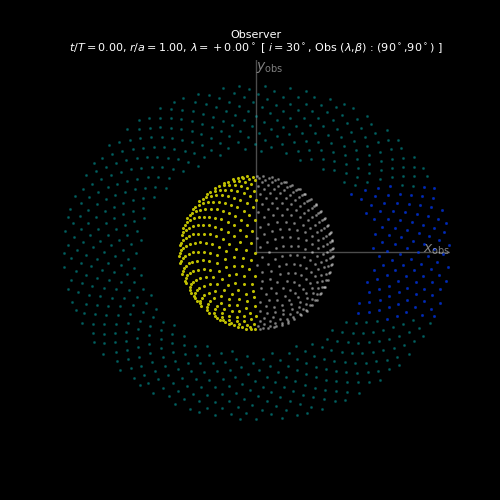

In [67]:
RP._plot["fs"]=5
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

<IPython.core.display.Javascript object>


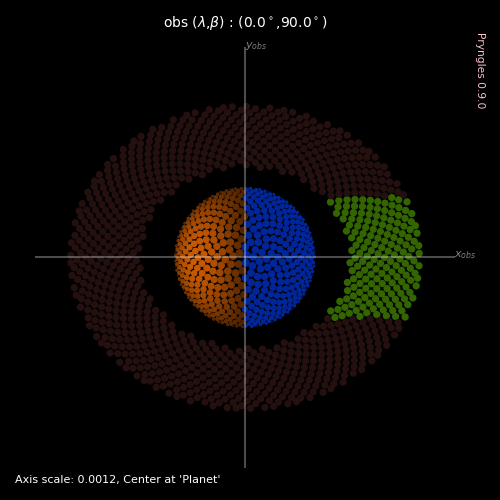

(0.18181818566061467, -6.003593414911354e-09)

In [68]:
sys.sg.plot2d(include=[P,R])

Number of spangles:

In [69]:
RP.Np,RP.Nr

(1000, 652)

In [70]:
P.sg.nspangles,R.sg.nspangles,(sys.data.name=="Planet").sum(),((sys.data.name=="Ring")&(~sys.data.hidden)).sum()

(987, 1064, 987, 1039)

Compared properties

In [71]:
RP.Rplanet,RP.Rstar,RP.Rp,RP.Rs,RP.Ri,RP.Re

(0.00040286669668487465,
 0.004650467260962157,
 0.08662929423602127,
 1.0,
 0.1299439413540319,
 0.21657323559005318)

In [72]:
sys.bodies["Planet"].radius,sys.bodies["Planet"].radius,\
sys.bodies["Planet"].radius/sys.bodies["Star"].radius,\
sys.bodies["Ring"].ri/sys.bodies["Star"].radius,sys.bodies["Ring"].re/sys.bodies["Star"].radius,

(0.00040286669668487465,
 0.00040286669668487465,
 0.08662929423602127,
 0.1299439413540319,
 0.21657323559005318)

Change stellar position:

<IPython.core.display.Javascript object>


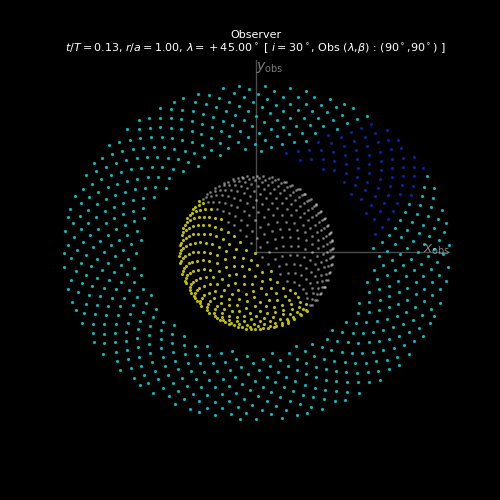

In [73]:
RP.changeStellarPosition(45*Consts.deg)
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

<IPython.core.display.Javascript object>


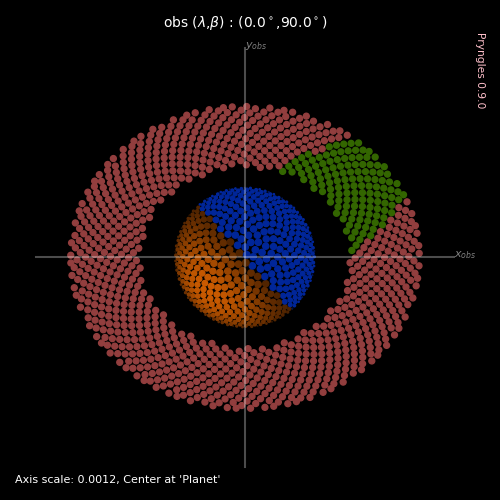

(0.1285648731490779, 0.12856486330305156)

In [74]:
sys.integrate(sys.sim.particles[1].P/8)
sys.update_perspective()
sys.sg.plot2d(include=[P,R])

<IPython.core.display.Javascript object>


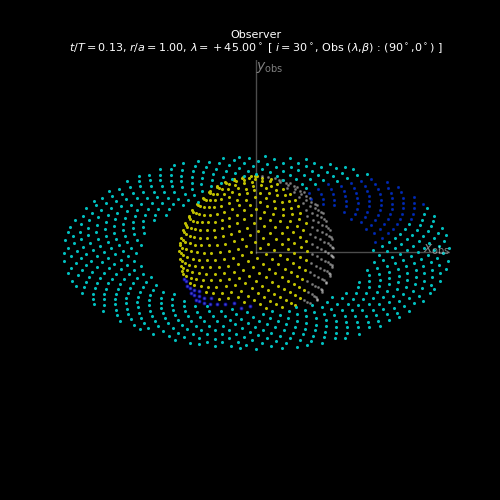

In [75]:
RP.changeObserver([90.0*Consts.deg,0.0*Consts.deg])
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

<IPython.core.display.Javascript object>


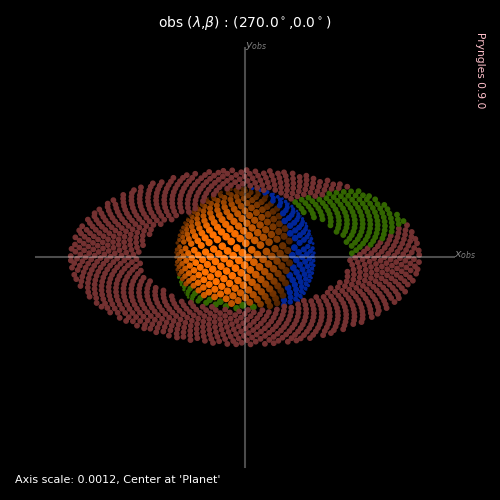

(0.1285648731490779, -8.861434635287762e-07)

In [76]:
sys.update_perspective(n_obs=Science.direction(-90,0))
sys.sg.plot2d(include=[P,R])

## Simple flux calculation

<IPython.core.display.Javascript object>


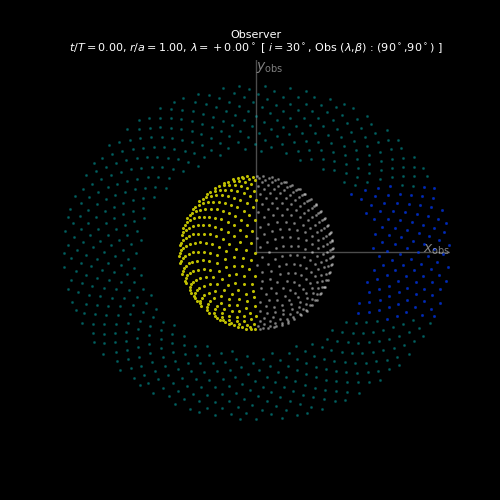

In [77]:
RP.changeStellarPosition(0.0*DEG)
RP.changeObserver([90.0*Consts.deg,90.0*Consts.deg])
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

<IPython.core.display.Javascript object>


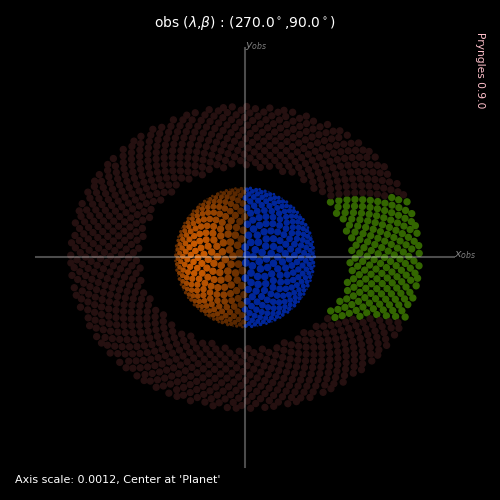

(0.18181818566061467, -6.003593434123292e-09)

In [78]:
sys.integrate(sys.sim.particles[1].P/12*0)
sys.update_perspective(n_obs=Science.direction(-90,90))
sys.sg.plot2d(include=[P,R])

In all calculations in the `RingedPlanet` interface the length units are stellar radii.

Now calculate flux from the planet:

In [79]:
RP.updateDiffuseReflection()
Flux_calculated=RP.Rip.sum()
Flux_calculated

1.1111755317854611e-07

The total expected flux without taking into account the law of reflection:

In [80]:
Flux_expected_tradition=(RP.Ap/2)/(4*np.pi*RP.rstar**2)
Flux_expected_tradition

5.071924228055711e-07

The flux reflected taking into account the law of reflection:

In [81]:
Flux_expected_real=(2*RP.Rp**2/3)/(4*np.pi*RP.rstar**2)*0.5
Flux_expected_real

1.0762957491768159e-07

Difference is due to the fact that Albedo is not exactly 0.5.

### System interface: areas

Area of the planet:

In [82]:
4*np.pi*P.radius**2

2.03954174648626e-06

Area computed from spangles:

In [83]:
cond=(sys.data.name=="Planet")
sys.data[cond].asp.sum()

2.0395417464862597e-06

If we use the areas from the light and observer point of view the value is slightly different due to discretization errors:

In [84]:
sys.data[cond].asp_obs.sum(),sys.data[cond].asp_luz.sum()

(2.035160338173772e-06, 2.0457642814974437e-06)

Area of the planet from above:

In [85]:
cond=(sys.data.name=="Planet")&(sys.data.visible)
(sys.data[cond].asp_obs*sys.data[cond].cos_obs).sum()

5.098854366215656e-07

In [86]:
cond=(sys.data.name=="Planet")&(sys.data.illuminated)
(sys.data[cond].asp_luz*sys.data[cond].cos_luz).sum()

5.098854366215648e-07

Actual transversal area:

In [87]:
np.pi*P.radius**2

5.09885436621565e-07

Area of the ring from above:

In [88]:
cond=(sys.data.name=="Ring")&(sys.data.visible)
(sys.data[cond].asp_obs*sys.data[cond].cos_obs).sum()

1.766294964535963e-06

In [89]:
cond=(sys.data.name=="Ring")&(sys.data.illuminated)&(~sys.data.hidden)
(sys.data[cond].asp_luz*sys.data[cond].cos_luz).sum()

-8.656742894061219e-23

Theoretical area of the ring:

In [90]:
np.pi*(R.re**2-R.ri**2)*np.cos(30*Const.deg)

1.7662949645359824e-06

### System interface: fluxes

<IPython.core.display.Javascript object>


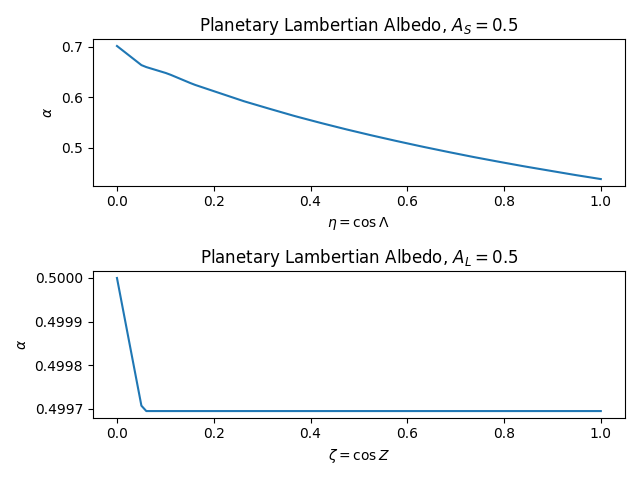

In [91]:
etas=np.linspace(0,1,100)
fig,axs=plt.subplots(2,1)

ax=axs[0]
ax.plot(etas,RP.getLambertianAlbedoPlanet(etas))
ax.set_xlabel(r"$\eta = \cos\Lambda$")
ax.set_ylabel(r"$\alpha$")
ax.set_title(rf"Planetary Lambertian Albedo, $A_S=${RP.AS}");

ax=axs[1]
ax.plot(etas,RP.getLambertianAlbedoRing(etas))
ax.set_xlabel(r"$\zeta = \cos Z$")
ax.set_ylabel(r"$\alpha$")
ax.set_title(rf"Planetary Lambertian Albedo, $A_L=${RP.AL}");

fig.tight_layout()

In [ ]:
## Playing ground

Catalogue of scatterers:

SCATTERERS_CATALOGUE

Create system:

nspangles=50

sys=System()
S=sys.add(kind="Star",nspangles=nspangles,
          radius=Consts.rsun/sys.ul,limb_coeffs=[0.65])
P=sys.add(kind="Planet",parent=S,nspangles=nspangles,
          a=0.2,e=0.0,radius=Consts.rsaturn/sys.ul,spangle_type=0)
R=sys.add(kind="Ring",parent=P,nspangles=nspangles,
          fi=1.5,fe=2.5,i=30*Consts.deg,roll=-90*Consts.deg)

sys.spangle_scatterers

Define a custom surface scatterer:

class CustomSurface(Scatterer):
    """Black body surface
    """
    def __init__(self,**params):
        if self.register(self,params):
            self.U=params["U"]
            self.V=params["V"]
    
    def get_albedo(self,eta,zeta,delta,lamb,**params):
        albedo=self.U*eta+self.V*eta
        return albedo

sys.spangle_scatterers[0]=(CustomSurface,dict(U="albedo_gray_normal",V="albedo_gray_spherical"))

sys.spangle_scatterers

sys.initialize_simulation()
sys.spangle_system()
sys.update_scatterers()

SCATTERERS_CATALOGUE

sys.data[sys.data.name=="Planet"].scatterer

SCATTERERS_CATALOGUE["17218226559613164855"].get_albedo(0.2,0.2,0,0)



### Previsualization comparison

RP=sys.ensamble_system(lamb=90*Consts.deg,beta=90*Consts.deg,AL=0.5,AS=0.5)

RP._plot["fs"]=5
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

sys.sg.plot2d(include=[P,R])

Number of spangles:

RP.Np,RP.Nr

P.sg.nspangles,R.sg.nspangles,(sys.data.name=="Planet").sum(),((sys.data.name=="Ring")&(~sys.data.hidden)).sum()

Compared properties

RP.Rplanet,RP.Rstar,RP.Rp,RP.Rs,RP.Ri,RP.Re

sys.bodies["Planet"].radius,sys.bodies["Planet"].radius,\
sys.bodies["Planet"].radius/sys.bodies["Star"].radius,\
sys.bodies["Ring"].ri/sys.bodies["Star"].radius,sys.bodies["Ring"].re/sys.bodies["Star"].radius,

Change stellar position:

RP.changeStellarPosition(45*Consts.deg)
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

sys.integrate(sys.sim.particles[1].P/8)
sys.update_perspective()
sys.sg.plot2d(include=[P,R])

RP.changeObserver([90.0*Consts.deg,0.0*Consts.deg])
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

sys.update_perspective(n_obs=Science.direction(-90,0))
sys.sg.plot2d(include=[P,R])

## Simple flux calculation

RP.changeStellarPosition(0.0*DEG)
RP.changeObserver([90.0*Consts.deg,90.0*Consts.deg])
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

sys.integrate(sys.sim.particles[1].P/12*0)
sys.update_perspective(n_obs=Science.direction(-90,90))
sys.sg.plot2d(include=[P,R])

In all calculations in the `RingedPlanet` interface the length units are stellar radii.

Now calculate flux from the planet:

RP.updateDiffuseReflection()
Flux_calculated=RP.Rip.sum()
Flux_calculated

The total expected flux without taking into account the law of reflection:

Flux_expected_tradition=(RP.Ap/2)/(4*np.pi*RP.rstar**2)
Flux_expected_tradition

The flux reflected taking into account the law of reflection:

Flux_expected_real=(2*RP.Rp**2/3)/(4*np.pi*RP.rstar**2)*0.5
Flux_expected_real

Difference is due to the fact that Albedo is not exactly 0.5.

### System interface: areas

Area of the planet:

4*np.pi*P.radius**2

Area computed from spangles:

cond=(sys.data.name=="Planet")
sys.data[cond].asp.sum()

If we use the areas from the light and observer point of view the value is slightly different due to discretization errors:

sys.data[cond].asp_obs.sum(),sys.data[cond].asp_luz.sum()

Area of the planet from above:

cond=(sys.data.name=="Planet")&(sys.data.visible)
(sys.data[cond].asp_obs*sys.data[cond].cos_obs).sum()

cond=(sys.data.name=="Planet")&(sys.data.illuminated)
(sys.data[cond].asp_luz*sys.data[cond].cos_luz).sum()

Actual transversal area:

np.pi*P.radius**2

Area of the ring from above:

cond=(sys.data.name=="Ring")&(sys.data.visible)
(sys.data[cond].asp_obs*sys.data[cond].cos_obs).sum()

cond=(sys.data.name=="Ring")&(sys.data.illuminated)&(~sys.data.hidden)
(sys.data[cond].asp_luz*sys.data[cond].cos_luz).sum()

Theoretical area of the ring:

np.pi*(R.re**2-R.ri**2)*np.cos(30*Const.deg)

### System interface: fluxes

etas=np.linspace(0,1,100)
fig,axs=plt.subplots(2,1)

ax=axs[0]
ax.plot(etas,RP.getLambertianAlbedoPlanet(etas))
ax.set_xlabel(r"$\eta = \cos\Lambda$")
ax.set_ylabel(r"$\alpha$")
ax.set_title(rf"Planetary Lambertian Albedo, $A_S=${RP.AS}");

ax=axs[1]
ax.plot(etas,RP.getLambertianAlbedoRing(etas))
ax.set_xlabel(r"$\zeta = \cos Z$")
ax.set_ylabel(r"$\alpha$")
ax.set_title(rf"Planetary Lambertian Albedo, $A_L=${RP.AL}");

fig.tight_layout()